# <span style='color: darkblue'>Credit Card Customer Segmentation</span>

## <span style='color: blue'>Introduction</span>

This project aims to segment a credit card company's clients into different groups so that they can apply different business strategies to each type.

The company's data engineering team has provided a mostly clean dataset containing:

1. `customer_id`: unique identifier for each customer.
1. `age`: customer age in years.
1. `gender`: customer gender ("M" of "F").
1. `dependent_count`: number of dependents of each customer.
1. `education_level`: level of education ("High School", "Graduate", etc).
1. `marital_status`: marital status ("Single", "Married", etc).
1. `estimated_income`: the estimated income for the customer projected by the data science team.
1. `months_on_book`: time as a customer in months.
1. `total_relationship_count`: number of times the customer contacted the company.
1. `months_inactive_12_mon`: numner of months the customer did not use the credit card in the last 12 months.
1. `credit_limit`: customer's credit limit.
1. `total_trans_amount`: the overall amount of money spent on the card by the customer.
1. `total_trans_count`: the overall number of times the customer used the card.
1. `avg_utilization_ratio`: daily average utilization ratio.

The company has made the decision that the K-means algorithm should be used to segment the data.

The expected outcome of this project is a group for each client with an explantion of the characteristics and differences of the groups for submission to the company.

## <span style='color: blue'>The Dataset</span>

*<span style='color: green'>Import required packages...</span>*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

*<span style='color: green'>Load and perform initial analysis of the dataset...</span>*

In [2]:
customers = pd.read_csv('customer_segmentation.csv')
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
customers.shape

(10127, 14)

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

It can be seen that most of the columns in the DataFrame are numeric, with only `gender`, `education_level` and `marital_status` being categorical.

The categorical columns will need to be transformed before modelling can take place.

There does not appear to be any missing values but the `customer_id` column should not be used for segmentation given that this is just a unique identifier for each customer.

*<span style='color: green'>Exclude `customer_id` from the DataFrame...</span>*

In [5]:
customers_noid = customers.drop('customer_id', axis=1)

*<span style='color: green'>Analyse correlations between numerical columns...</span>*

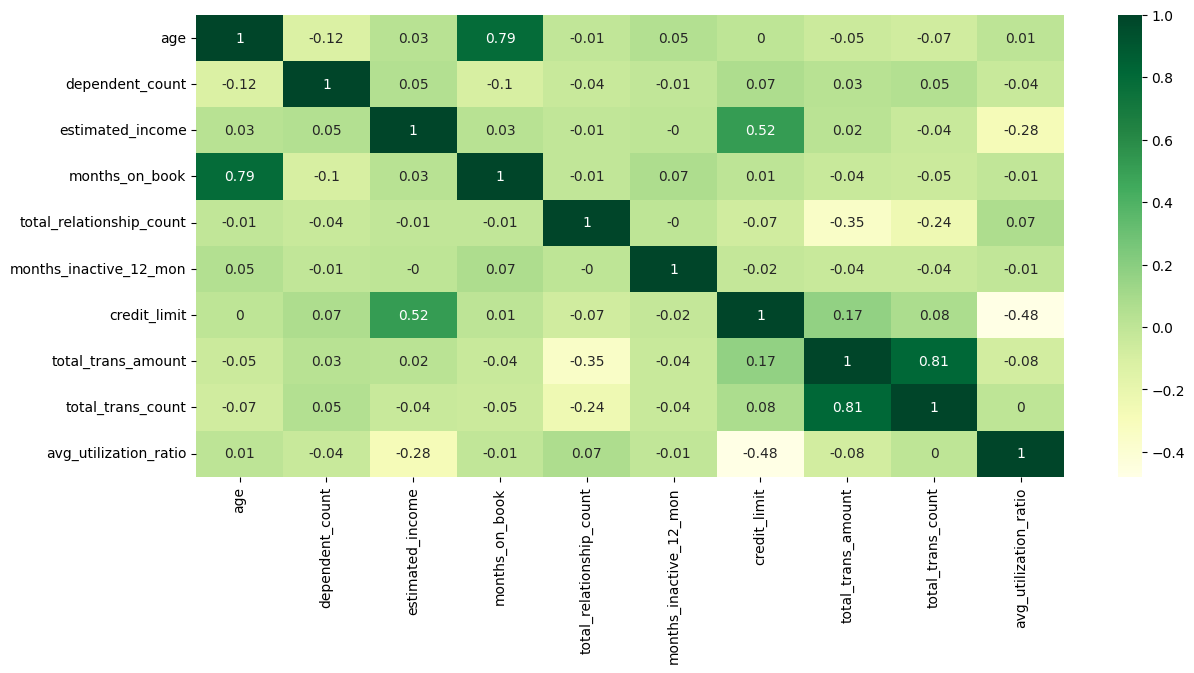

In [6]:
customers_corr = round(customers_noid.corr(numeric_only=True), 2)
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(customers_corr, annot=True, cmap='YlGn')
plt.show()

The majority of the numerical columns are weakly correlated.

However, `total_trans_count` has a strong positive correlation with `total_trans_amount` which in turn has a moderate negative correlation with `total_relationship_count`.

There is a strong positive correlation between `age` and `months_on_book` and `credit_limit` has a moderately positive correlation with `estimated_income`.

These correlations make some sense and could probably be expected.

*<span style='color: green'>Investigate the distributions of the numeric columns...</span>*

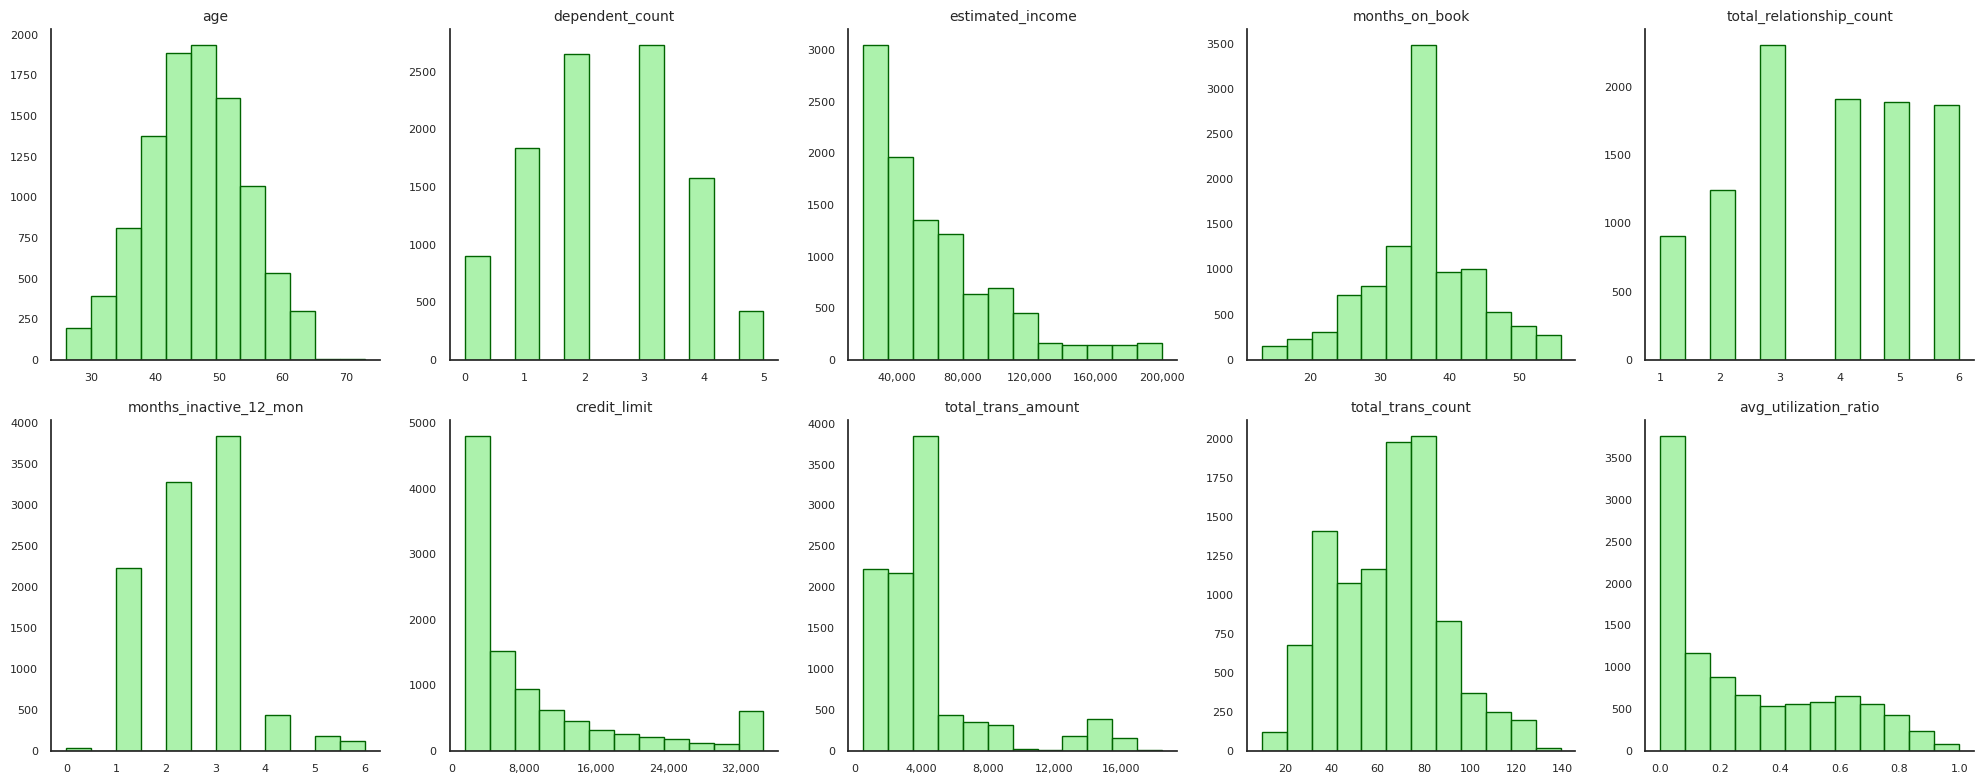

In [7]:
sns.set_theme(style='white')
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
numerics = customers_noid.select_dtypes(include='number').columns
for i, column in enumerate(numerics):
    sns.histplot(data=customers_noid,
                 x=column,
                 ax=axes[i],
                 bins=12,
                 kde=False,
                 color='lightgreen',
                 edgecolor='darkgreen')
    axes[i].set_title(column, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(left=False,
                        bottom=False,
                        labelsize=8)
    sns.despine(ax=axes[i])
    col_min = customers_noid[column].min()
    col_max = customers_noid[column].max()
    if col_max > 10000:
        axes[i].xaxis.set_major_locator(MaxNLocator(nbins=6))
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

The charts above demonstrate that the majority of the numeric columns are skewed with the remaining fairly normal.

## <span style='color: blue'>Feature Engineering</span>

The categorical columns, `gender`, `education_level` and `marital_status` shall now be transformed.

*<span style='color: green'>Inspect values of the categorical columns...</span>*

In [8]:
customers_noid['gender'].value_counts()

gender
F    5358
M    4769
Name: count, dtype: int64

In [9]:
customers_noid['education_level'].value_counts()

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

In [10]:
customers_noid['marital_status'].value_counts()

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64

*<span style='color: green'>Create a copy of the DataFrame for feature engineering...</span>*

In [11]:
customers_fe = customers_noid.copy()

`gender` is a binary category so 'M' shall be replaced with 1 and 'F' with 0.

*<span style='color: green'>Replace values in `gender` column...</span>*

In [12]:
customers_fe['gender'] = customers_fe['gender'].apply(lambda x: 1 if x == 'M' else 0)

As `education_level` has an order to it, define and replace the values with their rank (zero indexed).

*<span style='color: green'>Define `education_level` ranking...</span>*

In [13]:
education_level_ranking = {'Uneducated': 0,
                           'High School': 1,
                           'College': 2,
                           'Graduate': 3,
                           'Post-Graduate': 4,
                           'Doctorate': 5}

*<span style='color: green'>Substitute the `education_level`s with their ranks...</span>*

In [14]:
customers_fe['education_level'] = customers_fe['education_level'].apply(lambda x: education_level_ranking[x])

The column `marital_status` is unordered, therefore, cannot be ranked. One-hot encoding shall be used to create dummy variables from this column.

*<span style='color: green'>One-hot encode `marital_status`...</span>*

In [15]:
marital_status_ohe = pd.get_dummies(customers_fe[['marital_status']], drop_first=True).astype(int)

*<span style='color: green'>Merge dummies with `customers_fe` and drop the original `marital_status` column...</span>*

In [16]:
customers_fe = pd.concat([customers_fe, marital_status_ohe], axis=1)
customers_fe.drop('marital_status', axis=1, inplace=True)

*<span style='color: green'>Inspect the resulting DataFrame...</span>*

In [17]:
customers_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       10127 non-null  int64  
 1   gender                    10127 non-null  int64  
 2   dependent_count           10127 non-null  int64  
 3   education_level           10127 non-null  int64  
 4   estimated_income          10127 non-null  int64  
 5   months_on_book            10127 non-null  int64  
 6   total_relationship_count  10127 non-null  int64  
 7   months_inactive_12_mon    10127 non-null  int64  
 8   credit_limit              10127 non-null  float64
 9   total_trans_amount        10127 non-null  int64  
 10  total_trans_count         10127 non-null  int64  
 11  avg_utilization_ratio     10127 non-null  float64
 12  marital_status_Married    10127 non-null  int64  
 13  marital_status_Single     10127 non-null  int64  
 14  marita

In [18]:
customers_fe.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## <span style='color: blue'>Scaling the Data</span>

*<span style='color: green'>Use Scikit-Learn's `StandardScaler()` to transform the data to the same scale...</span>*

In [19]:
scaler = StandardScaler()
scaler.fit(customers_fe)

StandardScaler()

In [20]:
customers_scaled = pd.DataFrame(scaler.transform(customers_fe))

In [21]:
customers_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


## <span style='color: blue'>Choosing K</span>

Now that there is a scaled, numeric dataset, several models will be created and the inertia for each analysed.

*<span style='color: green'>Test models with Ks of 1 to 10 and measure their inertias...</span>*

In [22]:
inertias = []
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    output = model.fit_predict(customers_scaled)
    inertias.append(model.inertia_)

*<span style='color: green'>Visualise the inertias and choose a value for K...</span>*

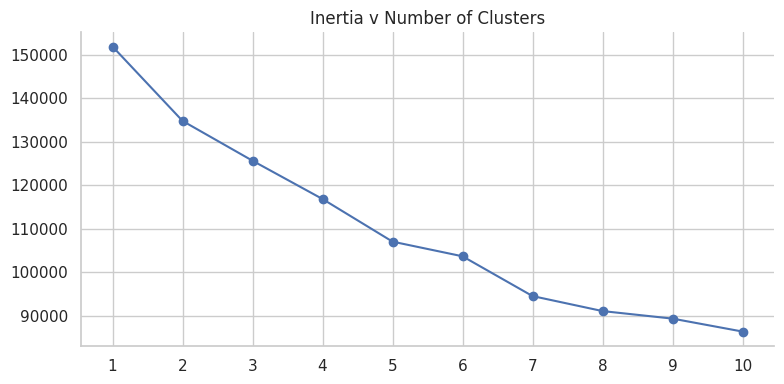

In [23]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11),
         inertias,
         marker='o')
sns.despine()
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia v Number of Clusters')
plt.tight_layout()
plt.show()

There is a marked slowdown in rate the inertias decrease between 5 and 6 clusters so 6 shall be used.

*<span style='color: green'>Finalise the cluster values with K=6</span>*

In [24]:
model = KMeans(n_clusters=6)
clusters = model.fit_predict(customers_scaled)
clusters

array([2, 3, 2, ..., 1, 0, 1], dtype=int32)

## <span style='color: blue'>Analysing Results</span>

*<span style='color: green'>Assign clusters back to `customers` as well as adding back the `customer_id`s...</span>*

In [25]:
customers['cluster'] = clusters + 1

In [26]:
customers['cluster'].value_counts()

cluster
2    2788
4    2491
3    1756
6    1448
5     914
1     730
Name: count, dtype: int64

Cluster 2 is the largest cluster with 3,208 members with cluster 1 the smallest with 738 members.

*<span style='color: green'>Analyse numeric column cluster allocation...</span>*

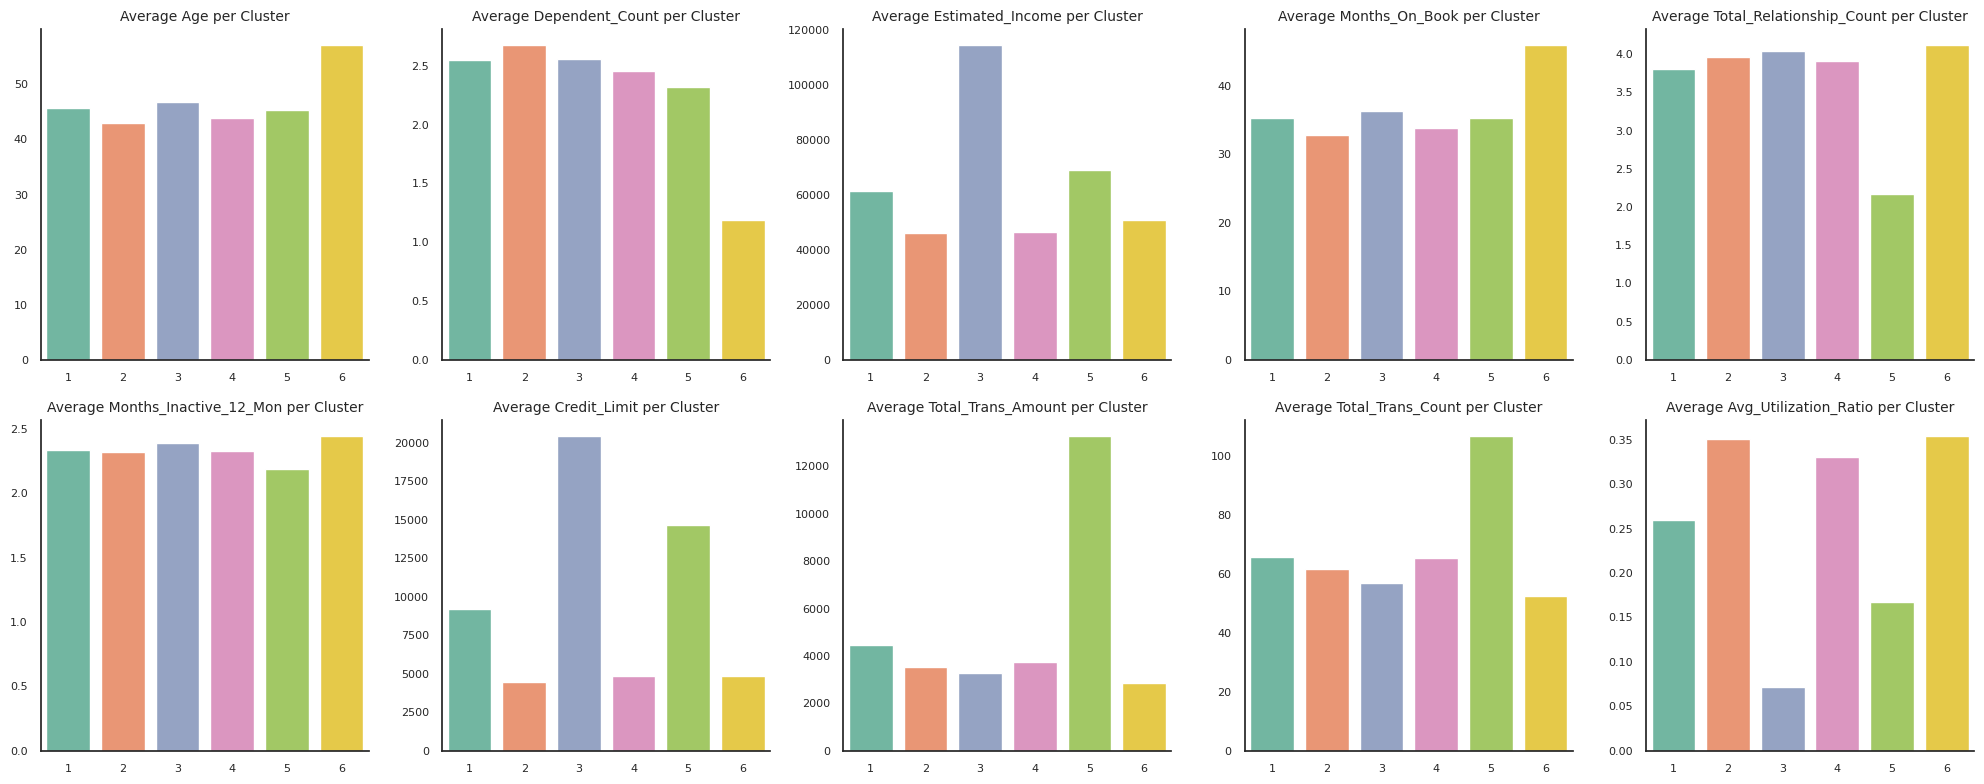

In [27]:
sns.set_theme(style='white')
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, column in enumerate(numerics):
    plot_data = customers.groupby('cluster')[[column]].mean()
    sns.barplot(data=plot_data,
                x=plot_data.index,
                y=plot_data[column],
                hue=plot_data.index,
                palette='Set2',
                legend=False,
                ax=axes[i])
    axes[i].set_title(f'Average {column.title()} per Cluster', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(left=False,
                        bottom=False,
                        labelsize=8)
    sns.despine(ax=axes[i])
plt.tight_layout()
plt.show()

*<span style='color: green'>Highly corellated variables by cluster...</span>*

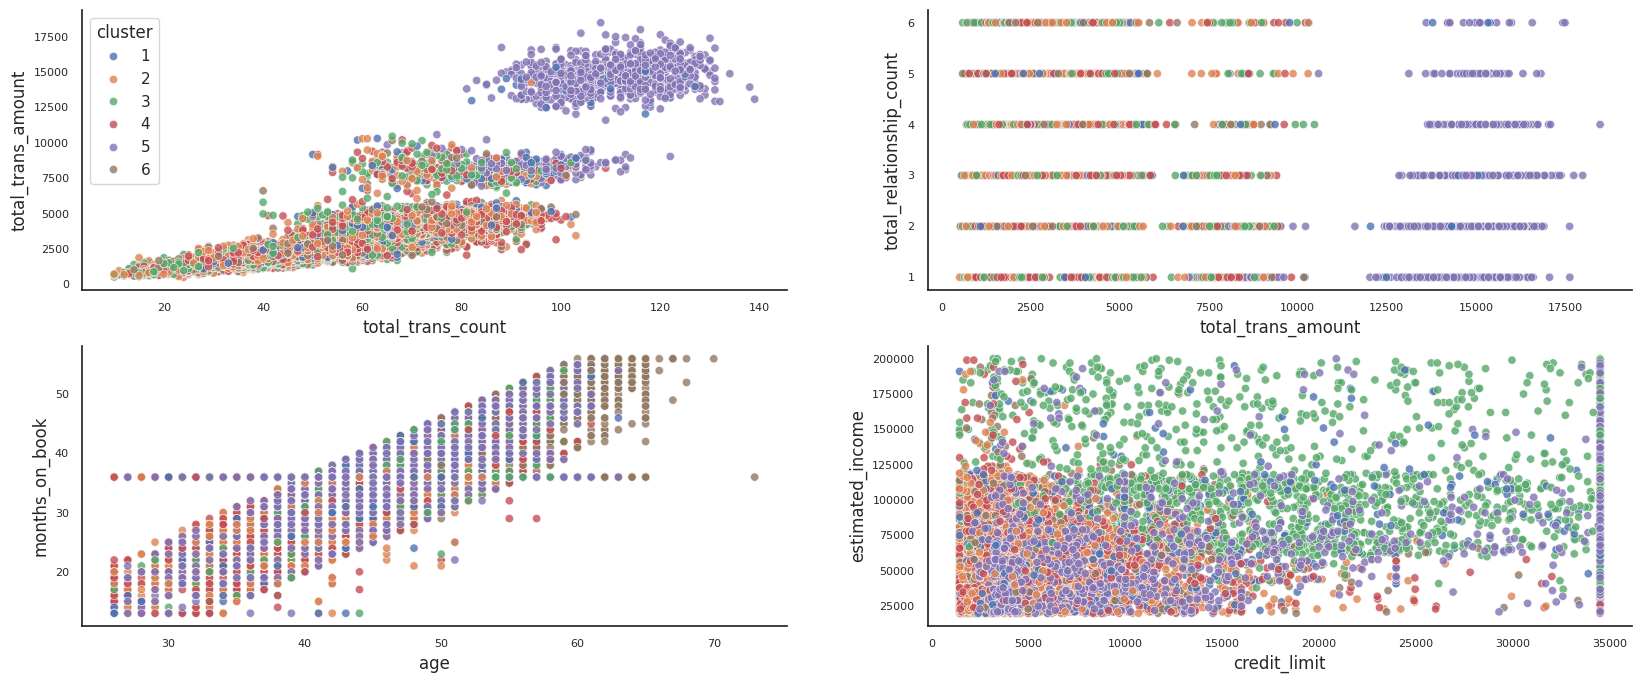

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()
sns.scatterplot(data=customers, x='total_trans_count', y='total_trans_amount', hue='cluster', palette='deep', alpha=0.8, ax=axes[0])
sns.scatterplot(data=customers, x='total_trans_amount', y='total_relationship_count', hue='cluster', palette='deep', alpha=0.8, ax=axes[1], legend=False)
sns.scatterplot(data=customers, x='age', y='months_on_book', hue='cluster', palette='deep', alpha=0.8, ax=axes[2], legend=False)
sns.scatterplot(data=customers, x='credit_limit', y='estimated_income', hue='cluster', palette='deep', alpha=0.8, ax=axes[3], legend=False)
for i in range(4):
    axes[i].tick_params(left=False, bottom=False, labelsize=8)
sns.despine()
plt.show()

The charts above show that:
* Cluster 5 contains customers with the highest average income but have low average total transaction amounts and average utilisation ratio.
* Cluster 4 has customers with the lowest average relationship count but the second highest average credit limit and the highest average transaction amount and total transactions.
* clusters 2 and 6 customers have the lowest estimated incomes and credit limits.

*<span style='color: green'>Relationships between categorical variables and clusters...</span>*

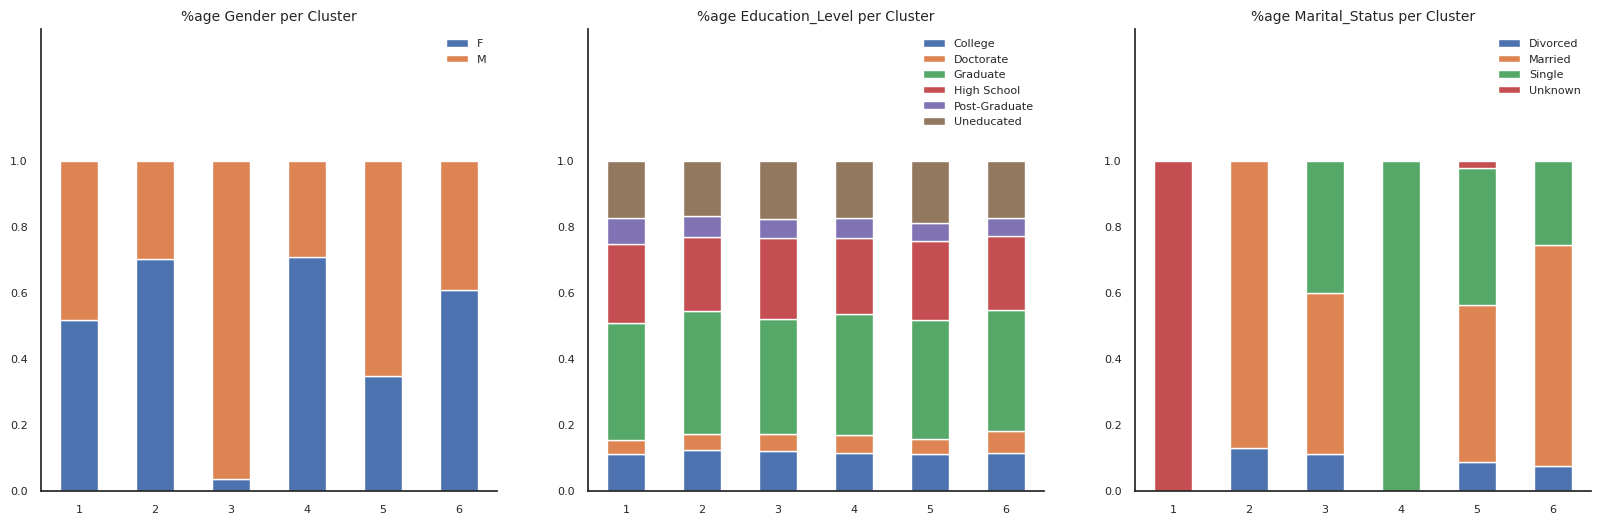

In [29]:
categoricals = customers.select_dtypes(include=['object'])
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, column in enumerate(categoricals):
    plot_data = pd.crosstab(index=customers['cluster'],
                            columns=customers[column],
                            values=customers[column],
                            aggfunc='size',
                            normalize='index')
    plot_data.plot.bar(stacked=True,
                       ax=axes[i])
    axes[i].set_title(f'%age {column.title()} per Cluster',
                      fontsize=10)
    axes[i].set_xlabel('')
    axes[i].legend(frameon=False,
                   fontsize=8)
    axes[i].set_ylim(0, 1.4)
    axes[i].tick_params(left=False, bottom=False, labelsize=8)
    ylabels = [x / 10 for x in range(0, 12, 2)]
    axes[i].set_yticks(ylabels)
    axes[i].set_yticklabels(ylabels)
    axes[i].tick_params(axis='x', labelrotation=0)
sns.despine()
plt.show()
                

It can be seen that:
* Cluster 5 is almost entirely male.
* Education levels are evenly split across clusters.
* There is no information on the marital status of any customers in Cluster 1.
* Cluster 2 customers are almost all married.
* Cluster 6 customers are almost all single.

## <span style='color: blue'>Conclusion</span>

All customers have now been allocated to a cluster and can be submitted to the company.

In [30]:
customer_groups = {}
for i in range(1, 7):
    customer_groups[f'customer_group_{i}'] = customers[customers['cluster'] == i]['customer_id'].values.tolist()

#### <span style='color: blue'>Highlights:</span>

**Cluster 1**: Lower credit limit and transaction amounts. All customers with a marital status of 'unknown' have been assigned to this group.

**Cluster 2**: Low income and credit limit but high use. Most members are married and a high proportion are female.

**Cluster 3**: Fairly low income with low credit limit and transaction amounts. Fairly high use. Majority of customers are single.

**Cluster 4**: Fairly high credit limit with a higher transaction amount and frequency.

**Cluster 5**: High income customers with a high credit limit but lower spend per transaction. Almost all customers in this group are male.

**Cluster 6**: Low earners with a low credit limit and smaller transaction amounts. Higher proportion of female customers that are mostly single.